In [ ]:
%sudo apt install tesseract-ocr
%pip uninstall pytesseract

### Getting data

In [ ]:
%sudo apt-get install poppler-utils
%pip install pdf2image

In [1]:
# Converting NDA.pdf to image
from pdf2image import convert_from_path

# Reading pdf
pdf = convert_from_path('SGPT.pdf')
for idx in range(1):
    pdf[idx].save('img_'+str(idx+1)+'.png', 'PNG')
print("Successfully converted to images.")

Successfully converted to images.


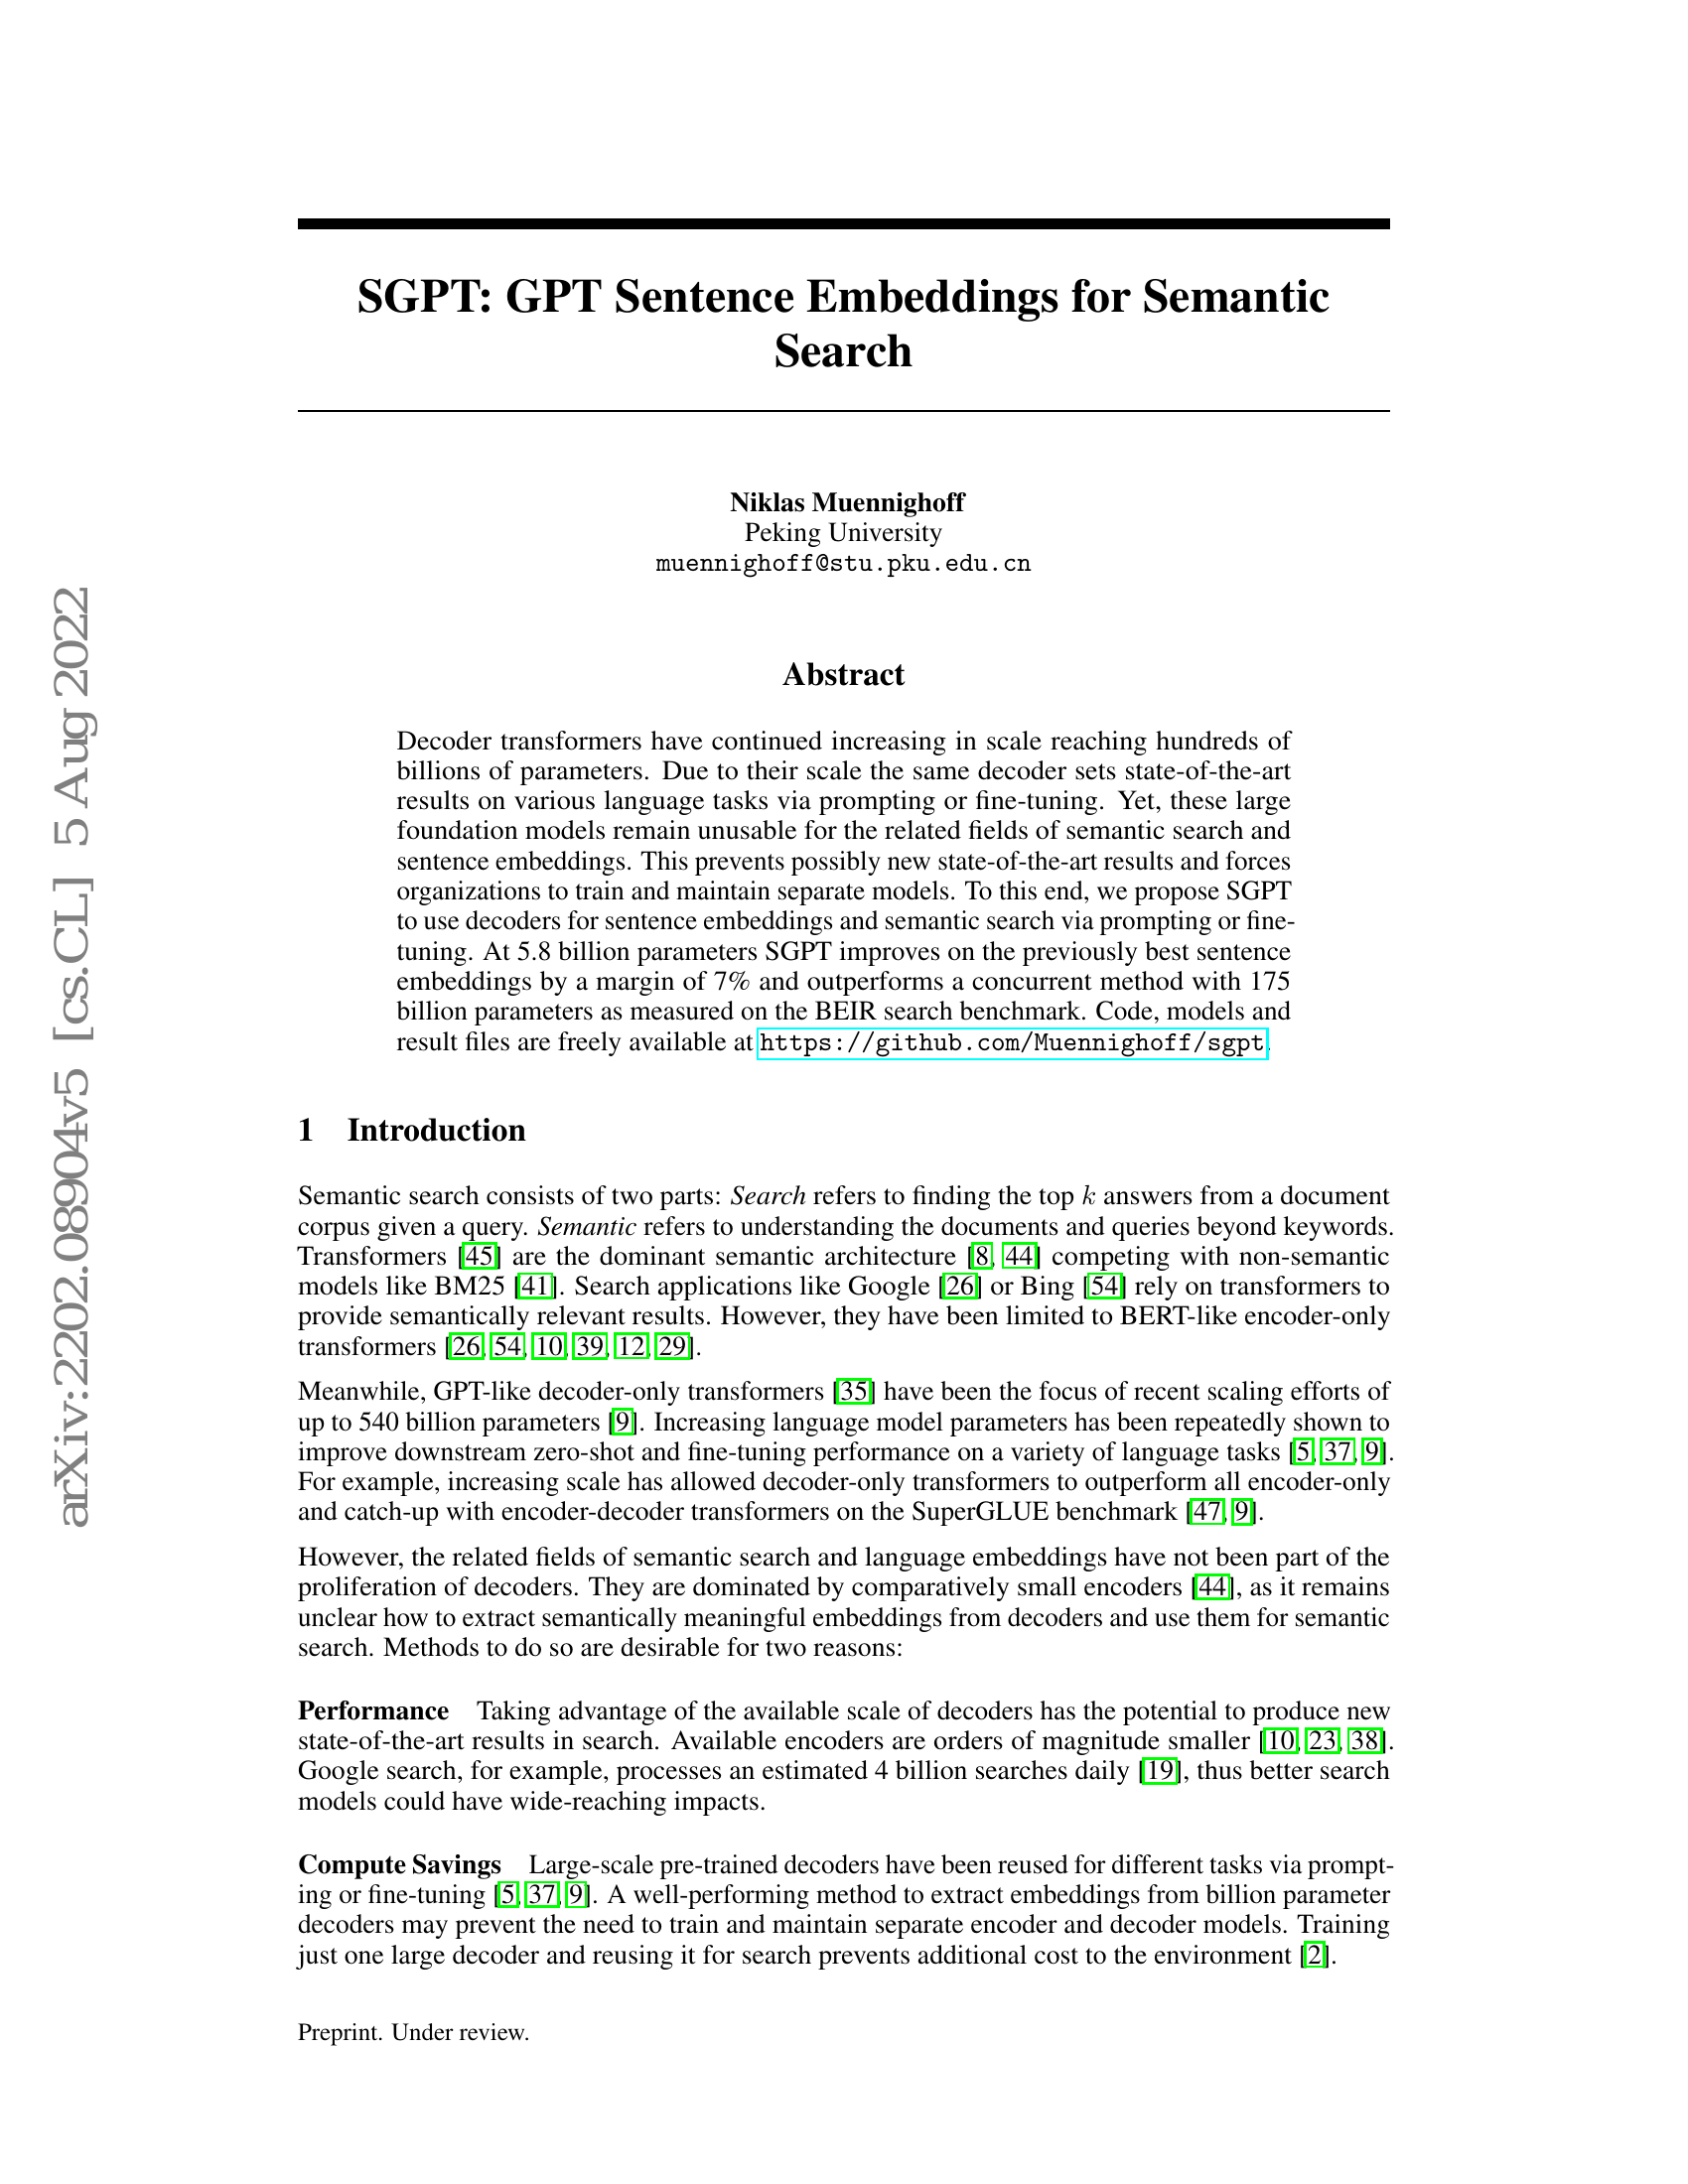

In [2]:
from PIL import Image

img = Image.open("img_1.png")
img = img.convert("RGB")
img

In [3]:
import pytesseract as pyt
import numpy as np

In [4]:
# Creating dataframe from image
ocr_df = pyt.image_to_data(img, output_type='data.frame')
ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1700,2200,-1,NaN
1,2,1,1,0,0,0,54,592,44,803,-1,NaN
2,3,1,1,1,0,0,54,592,44,803,-1,NaN
3,4,1,1,1,1,0,54,592,44,803,-1,NaN
4,5,1,1,1,1,1,55,1077,33,318,75,2202.08904v5
...,...,...,...,...,...,...,...,...,...,...,...,...
548,3,1,21,1,0,0,301,2038,231,22,-1,NaN
549,4,1,21,1,1,0,301,2038,231,22,-1,NaN
550,5,1,21,1,1,1,301,2038,83,22,96,Preprint.
551,5,1,21,1,1,2,395,2038,61,17,97,Under


In [5]:
# Removing null values from dataframe
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,55,1077,33,318,75,2202.08904v5
1,5,1,1,1,1,2,54,885,40,162,75,[cs.CL]
2,5,1,1,1,1,3,55,825,33,26,95,5
3,5,1,1,1,1,4,55,713,43,101,95,Aug
4,5,1,1,1,1,5,55,592,33,109,95,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
454,5,1,20,1,4,15,1163,1959,138,19,96,environment
455,5,1,20,1,4,16,1310,1955,35,27,79,[2].
456,5,1,21,1,1,1,301,2038,83,22,96,Preprint.
457,5,1,21,1,1,2,395,2038,61,17,97,Under


In [6]:
# Selecting columns with data types as float
float_cols = ocr_df.select_dtypes('float').columns
float_cols

Index([], dtype='object')

As none of the columns has float values, we'll proceed ahead.

In [7]:
# Replacing empty string with 'NaN' values from ocr_df
ocr_df = ocr_df.replace('^\s*$', np.nan, regex=True)
ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,55,1077,33,318,75,2202.08904v5
1,5,1,1,1,1,2,54,885,40,162,75,[cs.CL]
2,5,1,1,1,1,3,55,825,33,26,95,5
3,5,1,1,1,1,4,55,713,43,101,95,Aug
4,5,1,1,1,1,5,55,592,33,109,95,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
454,5,1,20,1,4,15,1163,1959,138,19,96,environment
455,5,1,20,1,4,16,1310,1955,35,27,79,[2].
456,5,1,21,1,1,1,301,2038,83,22,96,Preprint.
457,5,1,21,1,1,2,395,2038,61,17,97,Under


In [8]:
# Extracting words from the image
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'2202.08904v5 [cs.CL] 5 Aug 2022 arXiv. SGPT: GPT Sentence Embeddings for Semantic Search Niklas Muennighoff Peking University muennighoff@stu.pku.edu.cn Abstract Decoder transformers have continued increasing in scale reaching hundreds of billions of parameters. Due to their scale the same decoder sets state-of-the-art results on various language tasks via prompting or fine-tuning. Yet, these large foundation models remain unusable for the related fields of semantic search and sentence embeddings. This prevents possibly new state-of-the-art results and forces organizations to train and maintain separate models. To this end, we propose SGPT to use decoders for sentence embeddings and semantic search via prompting or fine- tuning. At 5.8 billion parameters SGPT improves on the previously best sentence embeddings by a margin of 7% and outperforms a concurrent method with 175 billion parameters as measured on the BEIR search benchmark. Code, models and result files are freely available at

### 2. Visualizing bounding boxes on words

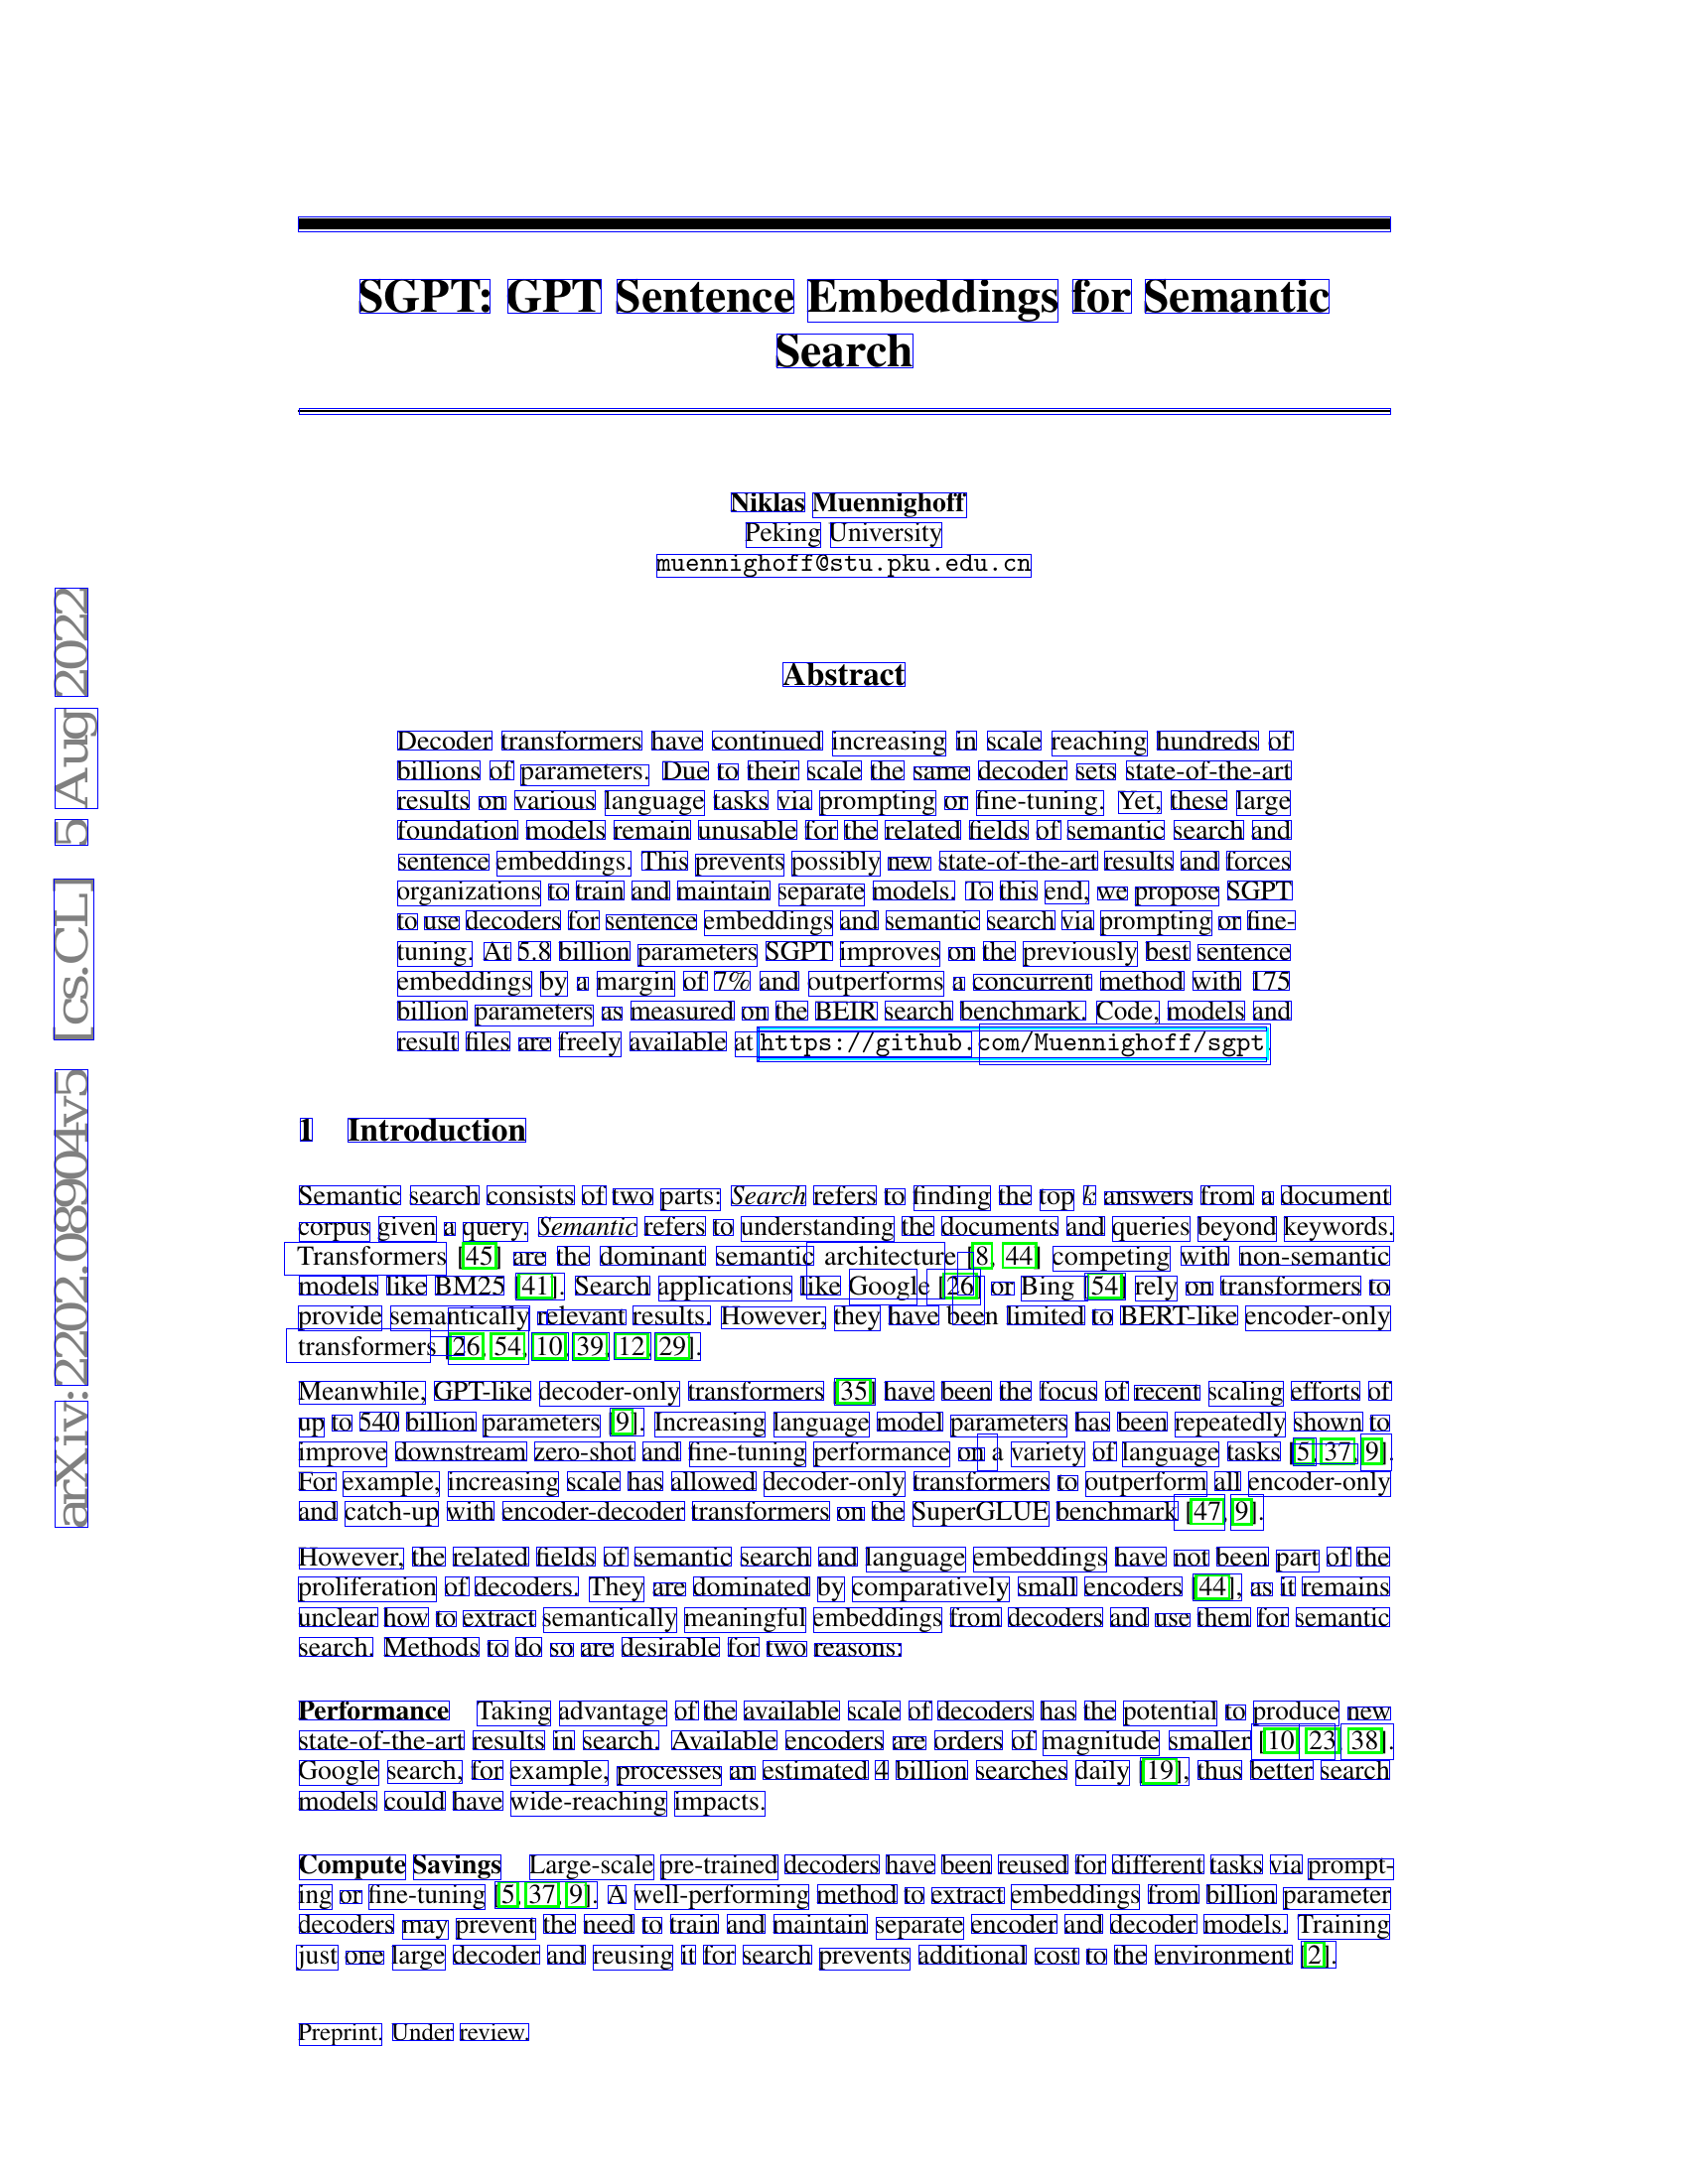

In [9]:
# Visualizing bounding boxes of the recognized words
from PIL import ImageDraw

coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # turning it into (left, top, left+width, top+height) to get the actual box
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(img, 'RGB')
for box in actual_boxes:
    draw.rectangle(box, outline='blue')
img

### 3. Embedding Words

In [10]:
words

'2202.08904v5 [cs.CL] 5 Aug 2022 arXiv. SGPT: GPT Sentence Embeddings for Semantic Search Niklas Muennighoff Peking University muennighoff@stu.pku.edu.cn Abstract Decoder transformers have continued increasing in scale reaching hundreds of billions of parameters. Due to their scale the same decoder sets state-of-the-art results on various language tasks via prompting or fine-tuning. Yet, these large foundation models remain unusable for the related fields of semantic search and sentence embeddings. This prevents possibly new state-of-the-art results and forces organizations to train and maintain separate models. To this end, we propose SGPT to use decoders for sentence embeddings and semantic search via prompting or fine- tuning. At 5.8 billion parameters SGPT improves on the previously best sentence embeddings by a margin of 7% and outperforms a concurrent method with 175 billion parameters as measured on the BEIR search benchmark. Code, models and result files are freely available at

In [11]:
ls_words = list(ocr_df.text)
ls_words

['2202.08904v5',
 '[cs.CL]',
 '5',
 'Aug',
 '2022',
 'arXiv.',
 nan,
 'SGPT:',
 'GPT',
 'Sentence',
 'Embeddings',
 'for',
 'Semantic',
 'Search',
 nan,
 'Niklas',
 'Muennighoff',
 'Peking',
 'University',
 'muennighoff@stu.pku.edu.cn',
 'Abstract',
 'Decoder',
 'transformers',
 'have',
 'continued',
 'increasing',
 'in',
 'scale',
 'reaching',
 'hundreds',
 'of',
 'billions',
 'of',
 'parameters.',
 'Due',
 'to',
 'their',
 'scale',
 'the',
 'same',
 'decoder',
 'sets',
 'state-of-the-art',
 'results',
 'on',
 'various',
 'language',
 'tasks',
 'via',
 'prompting',
 'or',
 'fine-tuning.',
 'Yet,',
 'these',
 'large',
 'foundation',
 'models',
 'remain',
 'unusable',
 'for',
 'the',
 'related',
 'fields',
 'of',
 'semantic',
 'search',
 'and',
 'sentence',
 'embeddings.',
 'This',
 'prevents',
 'possibly',
 'new',
 'state-of-the-art',
 'results',
 'and',
 'forces',
 'organizations',
 'to',
 'train',
 'and',
 'maintain',
 'separate',
 'models.',
 'To',
 'this',
 'end,',
 'we',
 'propose

In [12]:
# Bounding boxes to create a uniform embedding scheme]
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

In [13]:
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # turning it into (left, top, left+width, top+height) to get the actual box
    actual_boxes.append(actual_box)

In [14]:
boxes = []
width, height = img.size
for box in actual_boxes:
    boxes.append(normalize_bbox(box, width, height))

example = {}
# assert len(words) == len(boxes)
example['words'] = words
example['bbox'] = boxes

words = example['words']
normalized_word_boxes = example['bbox']

# assert len(words) == len(normalized_word_boxes)


In [ ]:
from transformers import LayoutLMTokenizerFast

tokenizer = LayoutLMTokenizerFast.from_pretrained("microsoft/layoutlm-base-uncased")

token_boxes = []
for word, box in zip(words, normalized_word_boxes):
    word_tokens = tokenizer.tokenize(word)
    token_boxes.extend([box] * len(word_tokens))
token_boxes

In [ ]:
# Truncation of token boxes
special_tokens_count = 2
max_seq_length = 512
pad_token_box = [0, 0, 0, 0]

if len(token_boxes) > max_seq_length - special_tokens_count:
    token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]

# Adding bounding boxes of cls + sep tokens
token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
encoding

In [ ]:
# Padding of token_boxes up the bounding boxes to the seq length
input_ids = tokenizer(' '.join(words), truncation=True)['input_ids']
input_ids

In [18]:
padding_length = max_seq_length - len(input_ids)
padding_length

0

In [ ]:
token_boxes += [pad_token_box] * padding_length
token_boxes

In [ ]:
encoding['bbox'] = token_boxes
encoding

In [20]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [21]:
import chromadb

# Connecting to Chroma DB server through HTTP client
client = chromadb.HttpClient(host="localhost", port=8000)
client.list_collections()

[Collection(name=mpNet-PriceHistory_collection),
 Collection(name=dateCheck_collection),
 Collection(name=test_collection),
 Collection(name=priceHistory_collection)]